In [50]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_selector
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line, labs
from sklearn.linear_model import ElasticNet

In [22]:
# Read the data
ames = pd.read_csv("/content/AmesHousing.csv")

# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()
ames

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,...,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,7937,Pave,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,8885,Pave,IR1,Low,AllPub,Inside,...,0,0,0,0,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,10010,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,4,2006,WD,Normal,170000


Make a pipeline that uses all the variables in the Ames dataset, and then fits Ridge Regression with Lambda = 1.

Cross-validate this pipeline and compare the results to the ordinary linear regression.

Then fit the model on the whole dataset and get the coefficients. Make a plot of these coefficients compared to the ones from ordinary linear regression.

In [23]:
# Creating response and predictor variables
X = ames.drop('SalePrice', axis=1)
y = ames['SalePrice']

# Splitting into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [30]:
# Defining the ColumnTransformer for preprocessing
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

# Defining the Ridge Regression pipeline
ridge_pipeline = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge(alpha=1))]
)

# Defining the ordinary linear regression pipeline
lr_pipeline = Pipeline(
    [("preprocessing", ct),
     ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

# Cross-validating the pipelines
ridge_scores = cross_val_score(ridge_pipeline, X, y, cv=5, scoring='r2')
linear_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='r2')

print("Ridge Scores")
print(ridge_scores)
print()
print("Linear Scores")
print(linear_scores)
print()

# Fitting the pipelines on the whole dataset
ridge_pipeline.fit(X, y)
lr_pipeline.fit(X, y)

# Ridge and Linear the coefficients
ridge_coefs = ridge_pipeline.named_steps['ridge_regression'].coef_
linear_coefs = lr_pipeline.named_steps['linear_regression'].coef_

Ridge Scores
[0.89627831 0.91741344 0.79268639 0.7825356  0.91432405]

Linear Scores
[-1.42602102e+21 -1.53036216e+21 -2.46556630e+20 -1.89368923e+22
 -1.29840327e+20]



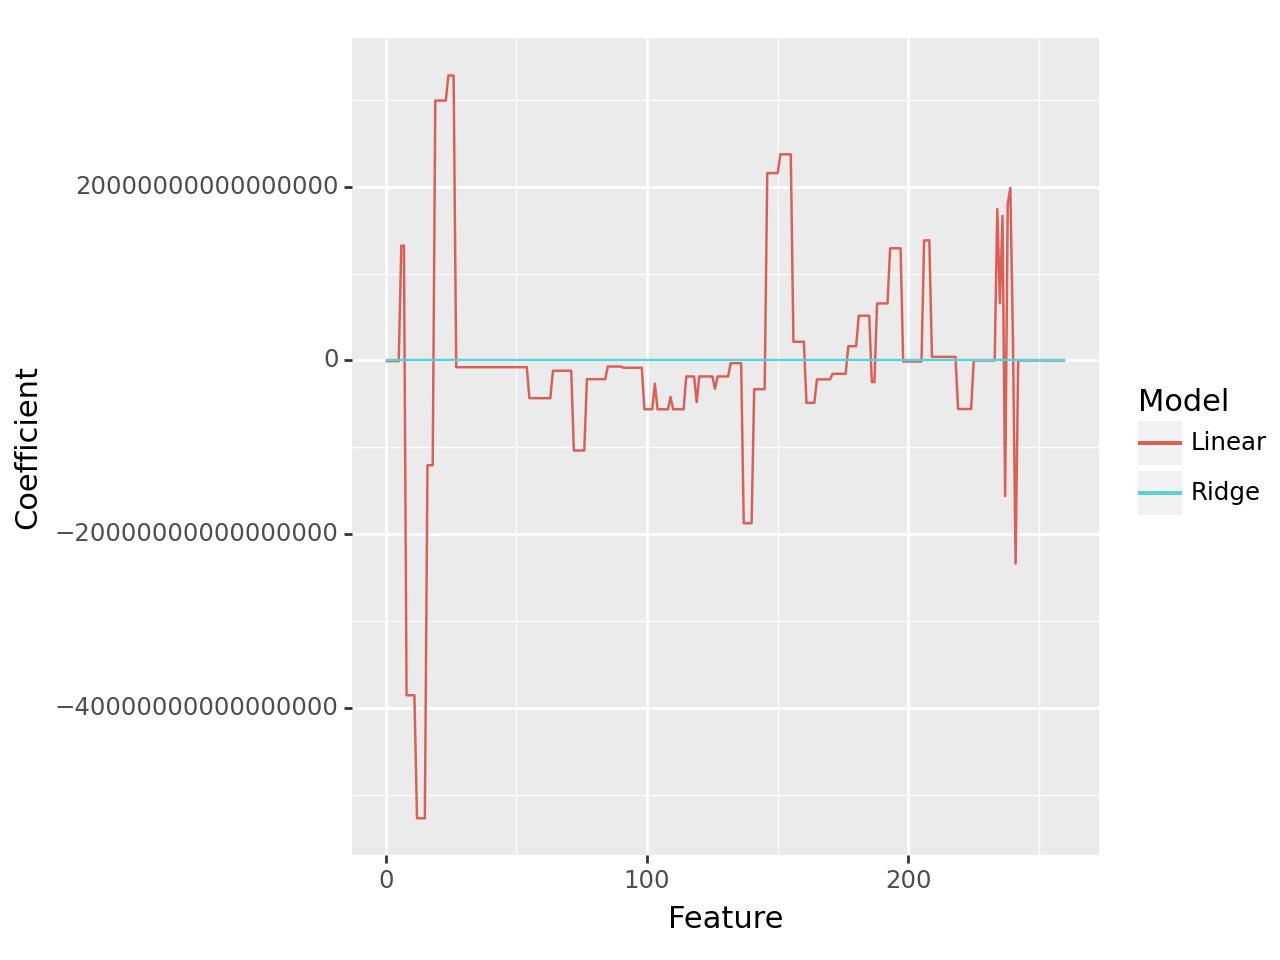

<Figure Size: (640 x 480)>

In [33]:
# Plot
df = pd.DataFrame({'Ridge': ridge_coefs, 'Linear': linear_coefs})
df = df.reset_index().melt(id_vars='index', var_name='Model', value_name='Coefficient')
df = df.rename(columns={'index': 'Feature'})
(ggplot(df, aes(x='Feature', y='Coefficient', color='Model')) + geom_line())

Using the same pipeline as previously, perform tuning on Lambda.

You should always try Lambda values on a log scale; that is, don’t use [1,2,3,4]; instead use something like [0.001, 0.01, 0.1, 1, 10]

In [40]:
# Ridge Regression pipeline
ridge_pipeline = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge(alpha=1))]  # lambda=alpha
    ).set_output(transform="pandas")

degrees = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv1 = GridSearchCV(ridge_pipeline, degrees, cv = 5, scoring='r2')

gscv1_fitted = gscv1.fit(X, y)

pd.DataFrame(data = {"alphas": [0.001, 0.01, 0.1, 1, 10], "scores": gscv1_fitted.cv_results_['mean_test_score']})

,alphas,scores
0,0.001,0.852428
1,0.010,0.852705
2,0.100,0.854894
3,1.000,0.860648
4,10.000,0.863224


Create a LASSO pipeline, and tune lambda.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS

In [41]:
from sklearn.linear_model import Lasso

ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

# Lasso Regression pipeline
lasso_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lasso_regression", Lasso(alpha=1))]
    ).set_output(transform="pandas")

alphas = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv2 = GridSearchCV(lasso_pipeline, alphas, cv = 5, scoring='r2')

gscv2_fitted = gscv2.fit(X, y)

pd.DataFrame(data = {"alphas": [0.001, 0.01, 0.1, 1, 10], "scores": gscv2_fitted.cv_results_['mean_test_score']})

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.164e+11, tolerance: 1.348e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.775e+11, tolerance: 1.474e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.616e+11, tolerance: 1.463e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

,alphas,scores
0,0.001,0.853952
1,0.010,0.854056
2,0.100,0.854892
3,1.000,0.855393
4,10.000,0.859060


In [48]:
# Fitting the best Ridge model on the whole dataset
best_ridge_alpha = gscv1.best_params_['ridge_regression__alpha']
ridge_pipeline.set_params(ridge_regression__alpha=best_ridge_alpha)
ridge_pipeline.fit(X, y)
ridge_coefs = ridge_pipeline.named_steps['ridge_regression'].coef_

# Fitting the best Lasso model on the whole dataset
best_lasso_alpha = gscv2.best_params_['lasso_regression__alpha']
lasso_pipeline.set_params(lasso_regression__alpha=best_lasso_alpha)
lasso_pipeline.fit(X, y)
lasso_coefs = lasso_pipeline.named_steps['lasso_regression'].coef_

# Fitting the OLS model on the whole dataset
lr_pipeline.fit(X, y)
linear_coefs = lr_pipeline.named_steps['linear_regression'].coef_

# Creating a dataframe for the coefficients
coefs_df = pd.DataFrame({
    'Ridge': ridge_coefs,
    'Lasso': lasso_coefs,
    'Linear': linear_coefs
})
print(coefs_df.describe())
coefs_df.head()


              Ridge          Lasso        Linear
count    261.000000     261.000000  2.610000e+02
mean     275.602398    -175.169453 -4.591728e+14
std     6685.746633   37663.907588  1.204459e+16
min   -39386.990439 -569124.252504 -5.272648e+16
25%    -2797.906061   -1379.486737 -2.487096e+15
50%      -29.904119       0.000000 -7.839853e+14
75%     2739.862984    3140.244604  6.312000e+03
max    28911.886211  111623.443057  3.280826e+16


,Ridge,Lasso,Linear
0,-4389.639345,-5323.100163,-8.133954e+13
1,1822.197237,0.000000,-8.133954e+13
2,-1189.029548,-0.000000,-8.133954e+13
3,4058.866485,3785.150692,-8.133954e+13
4,1974.971118,2037.680558,-8.133954e+13


Create an Elastic Net pipeline, and tune Lambda and alpha.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.

In [51]:
elastic_net_pipeline = Pipeline(
    [("preprocessing", ct),
     ("elastic_net", ElasticNet(alpha=1))]
    ).set_output(transform="pandas")

alphas = {
    'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10],
    'elastic_net__l1_ratio': [0.001, 0.01, 0.1]}

gscv3 = GridSearchCV(elastic_net_pipeline, alphas, cv = 5, scoring='r2')

gscv3_fitted = gscv3.fit(X, y)

gscv3_fitted.cv_results_['mean_test_score']

results = pd.DataFrame(gscv3_fitted.cv_results_)

# Extracting only the parameters and the mean test score
df_elastic = results.loc[:, ['param_elastic_net__alpha', 'param_elastic_net__l1_ratio', 'mean_test_score']]

print(df_elastic)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.483e+11, tolerance: 1.348e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.272e+11, tolerance: 1.474e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.082e+11, tolerance: 1.463e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

   param_elastic_net__alpha param_elastic_net__l1_ratio  mean_test_score
0                     0.001                       0.001         0.861947
1                     0.001                        0.01         0.861936
2                     0.001                         0.1         0.861810
3                      0.01                       0.001         0.862897
4                      0.01                        0.01         0.862909
5                      0.01                         0.1         0.863015
6                       0.1                       0.001         0.852375
7                       0.1                        0.01         0.852449
8                       0.1                         0.1         0.853209
9                         1                       0.001         0.812734
10                        1                        0.01         0.813059
11                        1                         0.1         0.816326
12                       10                       0

In [53]:
# Finding the row with the highest mean_test_score
best_row = results.loc[results['mean_test_score'].idxmax()]

# Extracting the best score and the corresponding parameters
best_score = best_row['mean_test_score']
best_params = best_row['params']

print(f"mean test score {best_score}")
print(f"parameters are {best_params}")

mean test score 0.8630146363355291
parameters are {'elastic_net__alpha': 0.01, 'elastic_net__l1_ratio': 0.1}


In [54]:
# Fitting the best Ridge model on the whole dataset
best_ridge_alpha = gscv1.best_params_['ridge_regression__alpha']
ridge_pipeline.set_params(ridge_regression__alpha=best_ridge_alpha)
ridge_pipeline.fit(X, y)
ridge_coefs = ridge_pipeline.named_steps['ridge_regression'].coef_

# Fitting the best Lasso model on the whole dataset
best_lasso_alpha = gscv2.best_params_['lasso_regression__alpha']
lasso_pipeline.set_params(lasso_regression__alpha=best_lasso_alpha)
lasso_pipeline.fit(X, y)
lasso_coefs = lasso_pipeline.named_steps['lasso_regression'].coef_

# Fitting the best Elastic Net model on the whole dataset
best_elastic_alpha = gscv3.best_params_['elastic_net__alpha']
best_l1_ratio = gscv3.best_params_['elastic_net__l1_ratio']
elastic_net_pipeline.set_params(elastic_net__alpha=best_elastic_alpha, elastic_net__l1_ratio=best_l1_ratio)
elastic_net_pipeline.fit(X, y)
elastic_coefs = elastic_net_pipeline.named_steps['elastic_net'].coef_

# Fitting the Linear Regression model on the whole dataset
lr_pipeline.fit(X, y)
linear_coefs = lr_pipeline.named_steps['linear_regression'].coef_

# Creating a dataframe for the coefficients
coefs_df1 = pd.DataFrame({
    'Ridge': ridge_coefs,
    'Lasso': lasso_coefs,
    'ElasticNet': elastic_coefs,
    'Linear': linear_coefs
})
print(coefs_df1)
print(coefs_df1.describe())

           Ridge        Lasso   ElasticNet        Linear
0   -4389.639345 -5323.100163 -2784.734855 -8.133954e+13
1    1822.197237     0.000000  1900.156402 -8.133954e+13
2   -1189.029548    -0.000000  -527.141068 -8.133954e+13
3    4058.866485  3785.150692  2146.583933 -8.133954e+13
4    1974.971118  2037.680558  1864.215411 -8.133954e+13
..           ...          ...          ...           ...
256  3140.314292  2630.120227  3182.266506  2.724000e+03
257   451.932615  2547.482118   249.280705  2.736000e+03
258 -4194.315053 -4912.558077 -4289.496914 -5.178000e+03
259  -667.085484  -739.831134  -599.538530 -7.680000e+02
260 -5856.621507 -3824.197327 -4401.947922 -6.420000e+03

[261 rows x 4 columns]
              Ridge          Lasso    ElasticNet        Linear
count    261.000000     261.000000    261.000000  2.610000e+02
mean     275.602398    -175.169453    287.056634 -4.591728e+14
std     6685.746633   37663.907588   4922.953471  1.204459e+16
min   -39386.990439 -569124.252504 -1683

The Elastic Net Regression Model had the best results with the lowest standard deviation, and lowest minimum and maximum values, when compared to the Ridge, Lasso, and OLS models.